In [14]:
import rasterio
from rasterio.plot import show
from rasterio.coords import BoundingBox
from rasterio import windows
from rasterio import warp
from rasterio import mask
import numpy as np
import matplotlib.pyplot as plt
import rasterio.plot as plot
from matplotlib.patches import Rectangle

In [15]:
url_imagen = 'D:\Memoria\Codigo\AraucoNursery\PROYECTOS\VIVERO\imagenes\imagen_mesones_rgb.tif'

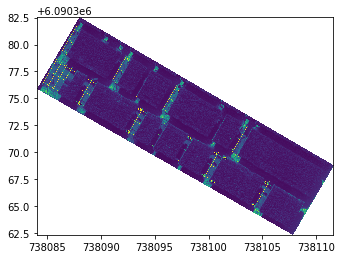

In [12]:
raster = rasterio.open(url_imagen)
show(raster)

In [16]:
print(raster.height,raster.width,raster.transform,raster.crs)

1823 2488 | 0.01, 0.00, 738084.06|
| 0.00,-0.01, 6090382.52|
| 0.00, 0.00, 1.00| EPSG:32718


In [17]:

window_slice = windows.Window(0,0,100,100)
print(window_slice)

Window(col_off=0, row_off=0, width=100, height=100)


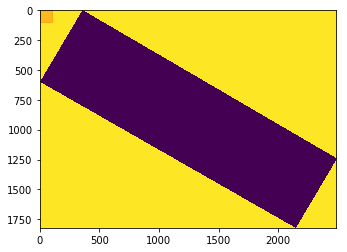

In [18]:
datos_b1 = raster.read(1)
plt.imshow(datos_b1)
ax = plt.gca()
ax.add_patch(Rectangle((window_slice.col_off,window_slice.row_off),
                       width=window_slice.width,
                       height=window_slice.height,fill=True,alpha=.2,
                 color="red"))

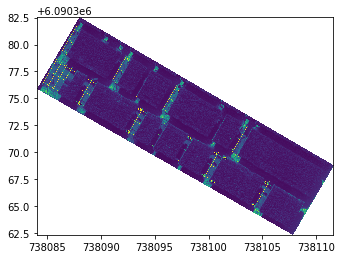

In [13]:
show(raster)

In [44]:
# numero de capas
print(raster.count)
print(raster.width)
print(raster.height)
print(raster.bounds)


4
2488
1823
BoundingBox(left=738084.0554489046, bottom=6090362.356968589, right=738111.5727206552, top=6090382.5193425445)


In [62]:
from pyproj import Proj, transform

inProj = Proj(init='EPSG:32718')
outProj = Proj(init='epsg:3035')
x1,y1 = (-72.381572,-35.30144)
x2,y2 = (-72.381570,-35.301499)

distance = np.sqrt((x2-x1)**2 +(y2-y1)**2)

In [60]:
print(distance)

5.903388857314529e-05
